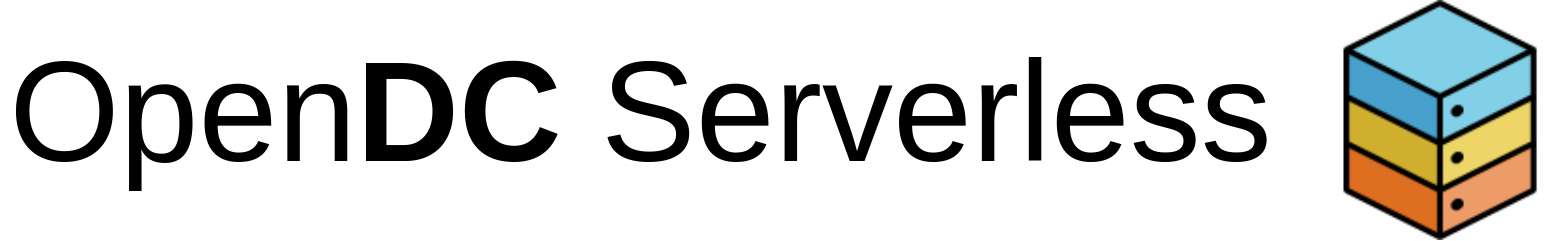
# Realistic Azure Trace Generator
This Notebook presents an approach for generating realistic traces out of the Azure Functions Dataset released in June 2020

This work accompanies the OpenDC Serverless bachelors thesis paper by Soufiane Jounaid within @Large Research

Vrije Universiteit Amsterdam 2020.

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import copy as cp
import seaborn as sns
import math
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from matplotlib import pyplot as plt
from scipy.stats import lognorm
from scipy.stats import burr
from scipy.stats import kstest
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF
import warnings

In [15]:
warnings.filterwarnings('ignore')

lnormpar is a log likelihood estimator for parameters of a lognormal distribution, this will mainly be used to build distribuitions of the function's execution times and memory allocations

In [3]:
r = robjects.r
robjects.numpy2ri.activate()
r.source('resources/lnormpar.R')

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


## Pre-processing (skip if processed available)

### Reading files into memory

In [4]:
invocations = pd.read_csv("resources/dataset/invocations_per_function_md.anon.d01.csv", index_col=False)
exec_times  = pd.read_csv("resources/dataset/function_durations_percentiles.anon.d01.csv", index_col=False)
memory_alloc= pd.read_csv("resources/dataset/app_memory_percentiles.anon.d01.csv", index_col=False)

### Merging invocations, execution time and memory allocation into a single dataframe 

In [ ]:
invoc_exec_merged = pd.merge(invocations, exec_times, on=["HashOwner","HashApp","HashFunction"])
functions = pd.merge(invoc_exec_merged, memory_alloc, on=["HashOwner","HashApp"], how="left")
functions.reset_index(inplace=True,drop=True)

### Filtering out unwanted duplicates 

In [ ]:
unwanted = pd.concat(g for _, g in functions.groupby("HashFunction") if len(g) > 1).sort_values(by="HashFunction")

In [ ]:
for row in unwanted.HashFunction:
    if (row in unwanted.HashFunction.values):
        functions = functions[functions.HashFunction != row]
functions.reset_index(inplace=True,drop=True)

#### Filtering out functions based on how often they are invoked
The idle threshold parameter is used to determine which functions to filter out, once functions reach an idle time percentage larger than the threshold, they are selected for removal 

In [ ]:
def filter_functions(functions, threshold, inverse):
    to_drop = []

    for index,row in enumerate(functions.values, start=0):
        count = 0

        for i in range(1440):
            if (row[i+4] != 0):
                count += 1
        
        if (count / 1440 > threshold):
            if inverse is True:
                to_drop.append(index)
            else:
                continue
        else:
            if inverse is True:
                continue
            else:
                to_drop.append(index)
    functions.drop(to_drop, inplace=True)
    functions.reset_index(drop=True, inplace=True)

In [ ]:
filter_functions(functions, 0.20, False)

## Proccesed input (if available)
### Azure Function Dataset 

In [4]:
functions = pd.read_csv("resources/dataset/processed/FunctionsDay1.csv", index_col=False)

### OpenDC Serverless Hybrid Histogram reproduction experiment sample

In [5]:
sample = pd.read_csv("resources/sample/functions.csv", index_col=False)

## Building distributions

### Utility

In [6]:
def empirical_sample(size, ecdf):
    inv_cdf = interp1d(ecdf.y, ecdf.x, bounds_error = False, assume_sorted=True)
    r = np.random.uniform(0, 1, size)
    return inv_cdf(r)

In [7]:
def mle_lognorm(minimum, maximum, mean, size):
    estimate = r.lnormpar(x1=minimum,xn=maximum,xbar=mean,n=size)
    return estimate[0], estimate[1], estimate[2], estimate[3]

In [8]:
def invoc_format_func(value, tick_number):
    switcher ={
        10:'10',
        1000:'1000',
        100000:'100 000',
        10000000:'10 000 000'
    }
    return switcher.get(value)

def exec_time_format_func(value, tick_number):
    switcher ={
        0.001:'1ms',
        0.1:'100ms',
        1:'1s',
        10:'10s',
        60:'1min',
        600:'10min',
        3600:'1hr',
        36000:'10hr',
        86400:'1d'
    }
    return switcher.get(value)

def mem_alloc_format_func(value, tick_number):
    switcher ={
        10:'10',
        100:'100',
        1000:'1000',
    }
    return switcher.get(value)

### Invocations CDF

In [17]:
def plot_invocavg_dist(invoc_sample, label):
    invoc_cdf = ECDF(invoc_sample)
    fig, ax = plt.subplots(figsize=(6, 4), dpi= 100)
    
    plt.xscale('log')

    fig.suptitle('Distribution of function invocations')

    ax.set_ylabel('CDF', fontsize=12)
    ax.set_xlabel('Invocations', fontsize=12)

    ax.plot(invoc_cdf.x, invoc_cdf.y, label=label)
    return fig, ax

#### Reproducing ATC20 paper fit to test the data & comparing the fit of the OpenDC Serverless experiment sample


In [18]:
invoc_sample = []
for function in functions.values:
    invoc_sample.append(sum(function[4:1444]))

In [19]:
experiment_sample = []
for function in sample.values:
    experiment_sample.append(sum(function[4:1444]))
experiment_invoc_cdf = ECDF(experiment_sample)

**Important note**: The experiment sample was sampled from midrange popularity (median sum of invocations) applications therefore the sample's distribution is likely to cutoff near the median invocations 

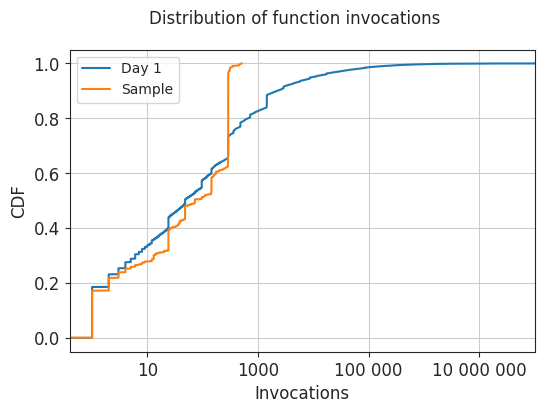

In [20]:
with sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax = plot_invocavg_dist(invoc_sample, label='Day 1')
    ax.plot(experiment_invoc_cdf.x, experiment_invoc_cdf.y, label='Sample')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.set_xlim([0,100000000])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(invoc_format_func))
    ax.legend(loc='best')

#### Generating invocations from ECDF

In [21]:
def invoc_dist(functions, function_index):
    sample = functions.values[function_index][4:1444]
    return ECDF(sample)

### Execution time CDF

In [25]:
def plot_execavg_dist(exec_sample, label):
    exec_cdf = ECDF(exec_sample)

    fig, ax = plt.subplots(figsize=(6, 4), dpi= 100)

    fig.suptitle('Distribution of function execution times')

    plt.xscale('log')

    ax.xaxis.set_major_formatter(plt.FuncFormatter(exec_time_format_func))
    ax.set_xticks([0.001,0.1,1,10,60,600,3600,36000,86400])

    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('CDF', fontsize=12)

    ax.plot(exec_cdf.x, exec_cdf.y, label=label)
    return fig, ax

#### Reproducing ATC20 paper fit to test the data & comparing the fit of the OpenDC Serverless experiment sample

In [26]:
exec_sample = np.array([])
for i in functions.Average:
    exec_sample = np.append(exec_sample, i/1000.0)
exec_sample = exec_sample[exec_sample > 0.0]

In [27]:
experiment_sample = np.array([])
for i in sample.Average:
    experiment_sample = np.append(experiment_sample, i/1000.0)
experiment_sample = experiment_sample[experiment_sample > 0.0]
experiment_exec_cdf = ECDF(experiment_sample)

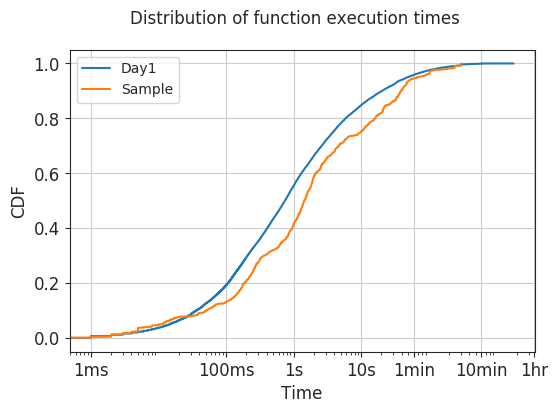

In [28]:
with sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax = plot_execavg_dist(exec_sample, 'Day1')
    ax.plot(experiment_exec_cdf.x, experiment_exec_cdf.y, label='Sample')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.legend(loc='best')

#### Comparing lognorm fit parameters to the ATC'20 paper

In [29]:
print(f"[ATC20] sigma:2.36, loc:0.0, log mean:-0.38")
shape, loc, scale = lognorm.fit(exec_sample, floc=0)
print(f"[Day1] sigma:{shape}, loc:{loc}, log mean:{np.log(scale)}")
shape, loc, scale = lognorm.fit(experiment_sample, floc=0)
print(f"[Sample] sigma:{shape}, loc:{loc}, log mean:{np.log(scale)}")

[ATC20] sigma:2.36, loc:0.0, log mean:-0.38
[Day1] sigma:2.4345713116976815, loc:0.0, log mean:-0.25566604436362217
[Sample] sigma:2.569594779877746, loc:0.0, log mean:0.3201420838845442


The fit seems to be very close to what is reported in the paper, the log mean and sigma are also in line with the values reported at ATC'20 (log mean -0.38 and sigma of 2.36)

#### Generating Execution times through a lognormal distribution

In [30]:
def exec_dist(functions, function_index):
    mu, sigma, mu_error, sigma_error = mle_lognorm(minimum=functions.Minimum[function_index]+1,
                                                   maximum=functions.Maximum[function_index],
                                                   mean=functions.Average[function_index],
                                                   size=functions.Count[function_index])
    return lognorm(s=sigma, scale=math.exp(mu))

#### Testing the lognormal distribution against the provided percentiles

Choose function to test against 

In [31]:
function_index = 78

{'0pct: 218   fit': 0.006423636214132737,
 '1pct: 343   fit': 0.05634966179784958,
 '25pct: 498  fit': 0.19925631810072442,
 '50pct: 658  fit': 0.38593002510864255,
 '75pct: 1048  fit': 0.7376533186732612,
 '99pct: 3749  fit': 0.999243555840065,
 '100pct: 4369 fit': 0.9997461989396664}

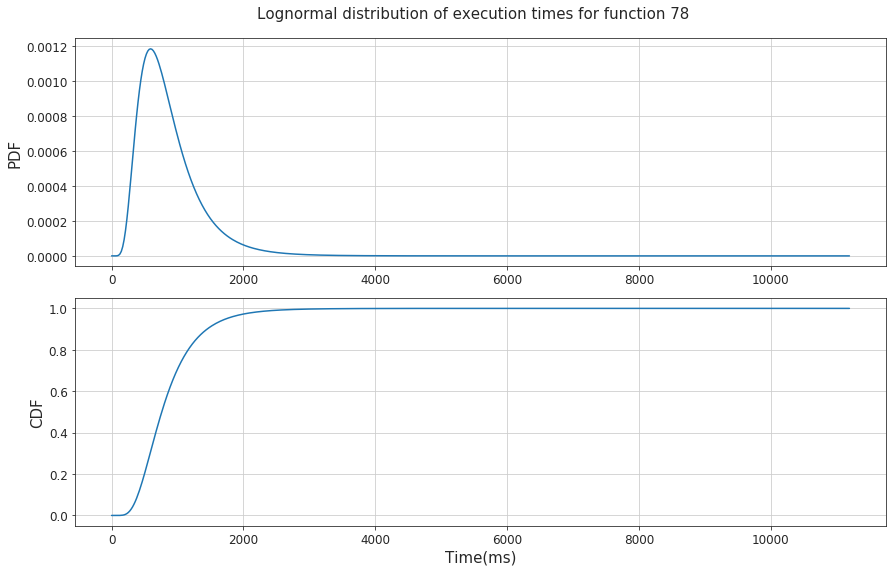

In [43]:
with sns.axes_style("ticks", {'axes.grid': True}):
    percentiles = [functions.percentile_Average_0[function_index],
                   functions.percentile_Average_1[function_index],
                   functions.percentile_Average_25[function_index],
                   functions.percentile_Average_50[function_index],
                   functions.percentile_Average_75[function_index],
                   functions.percentile_Average_99[function_index],
                   functions.percentile_Average_100[function_index]]

    line = np.linspace(0, functions.Maximum[function_index], functions.Count[function_index].astype(int))

    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plt.tight_layout()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


    fig.suptitle('Lognormal distribution of execution times for function {0}'.format(function_index), fontsize=15)

    ax[0].plot(line, exec_dist(functions, function_index).pdf(line))
    ax[0].set_ylabel('PDF', fontsize=15)

    ax[1].plot(line, exec_dist(functions, function_index).cdf(line))
    ax[1].set_xlabel('Time(ms)', fontsize=15)
    ax[1].set_ylabel('CDF', fontsize=15)
    
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    ax[0].tick_params(axis='both', which='minor', labelsize=12)

    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].tick_params(axis='both', which='minor', labelsize=12)

    pcts =  exec_dist(functions, function_index).cdf(percentiles)
{'0pct: {0}   fit'.format(percentiles[0]):pcts[0],
 '1pct: {0}   fit'.format(percentiles[1]):pcts[1],
 '25pct: {0}  fit'.format(percentiles[2]):pcts[2],
 '50pct: {0}  fit'.format(percentiles[3]):pcts[3],
 '75pct: {0}  fit'.format(percentiles[4]):pcts[4],
 '99pct: {0}  fit'.format(percentiles[5]):pcts[5],
 '100pct: {0} fit'.format(percentiles[6]):pcts[6],
}

### Memory Allocation CDF
For this section we will generate memory distributions per application instead of per function

In [44]:
def plot_memavg_dist(mem_cdf):
    fig, ax = plt.subplots(figsize=(6, 4), dpi= 100)

    fig.suptitle('Distribution of average allocated Mb of memory per application')

    plt.xscale('log')

    ax.xaxis.set_major_formatter(plt.FuncFormatter(mem_alloc_format_func))
    ax.set_xticks([10,100,1000])

    ax.set_xlabel('Allocated memory (MB)', fontsize=12)
    ax.set_ylabel('CDF', fontsize=12)

    ax.plot(mem_cdf.x, mem_cdf.y, label='Day1')
    return fig, ax

#### Reproducing ATC20 paper fit to test the data and comparing it to the sample used in the OpenDC Serverless paper
The CDF of the data is relatively true to the paper, however the burr fit could use some optimization

In [45]:
mem_sample = np.array([])
for i in functions.AverageAllocatedMb:
    mem_sample = np.append(mem_sample, i)
    
mem_cdf = ECDF(mem_sample)

In [46]:
experiment_sample = np.array([])
for i in sample.AverageAllocatedMb:
    experiment_sample = np.append(experiment_sample, i)
    
experiment_mem_cdf = ECDF(experiment_sample)

Burr fit parameters are taken from the paper and slightly tweaked to produce a better fit

In [47]:
c, d = 11.652, 0.500

mem_burr = burr(c=c, d=d, scale=160.083)
mem_burr_cdf = ECDF(mem_burr.rvs(size=10000))

x_burr = np.linspace(burr.ppf(0.01, c, d, scale=150.083),
                1200, 1000)

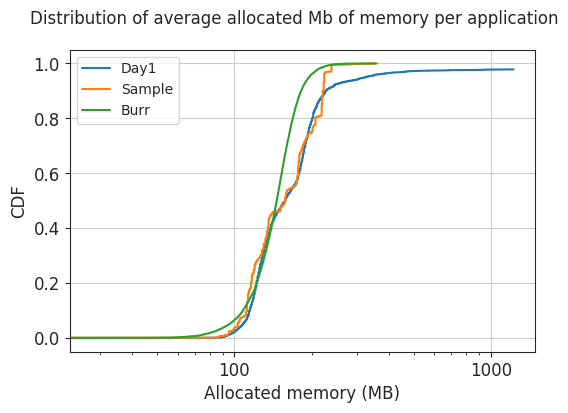

In [50]:
with sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax = plot_memavg_dist(mem_cdf)
    ax.plot(experiment_mem_cdf.x, experiment_mem_cdf.y, label='Sample')
    ax.plot(mem_burr_cdf.x, mem_burr_cdf.y, label='Burr')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.legend(loc='best')

#### Generating Allocated memory through a lognormal distribution

In [51]:
def mem_dist(functions, function_index):
    mu, sigma, mu_error, sigma_error = mle_lognorm(minimum=functions.AverageAllocatedMb_pct1[function_index],
                                                   maximum=functions.AverageAllocatedMb_pct100[function_index],
                                                   mean=functions.AverageAllocatedMb[function_index],
                                                   size=functions.SampleCount[function_index])
    return lognorm(s=sigma, scale=math.exp(mu))

#### Testing the lognormal distribution against the provided percentiles

Choose function to test against 

In [52]:
function_index = 78

{'0pct: 119.0   fit': 0.00023494112899933266,
 '1pct: 127.0   fit': 0.007949876796303334,
 '25pct: 136.0  fit': 0.10235874133102796,
 '50pct: 148.0  fit': 0.5569943557611428,
 '75pct: 157.0  fit': 0.8705180044697629,
 '99pct: 218.0  fit': 0.9999999999805947,
 '100pct: 225.0 fit': 0.9999999999995202}

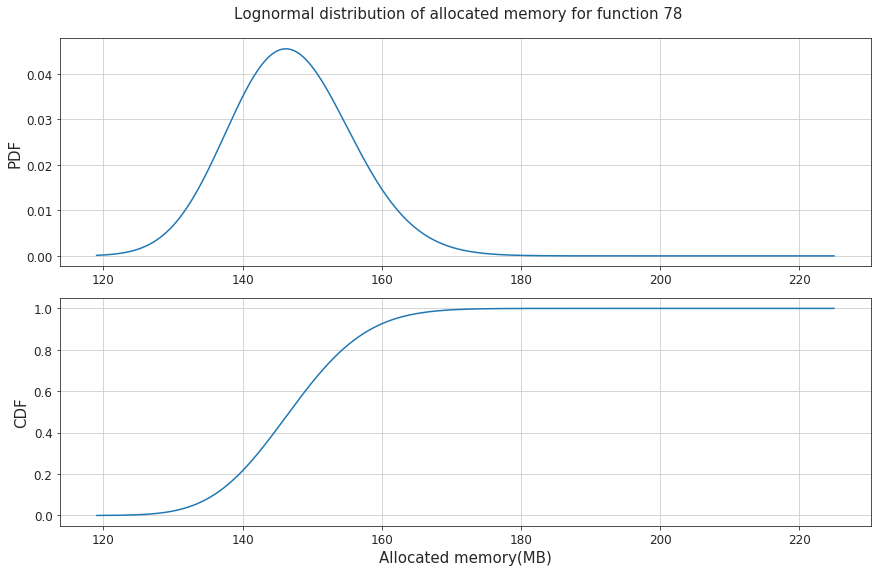

In [58]:
with sns.axes_style("ticks", {'axes.grid': True}):
    percentiles = [functions.AverageAllocatedMb_pct1[function_index],
                   functions.AverageAllocatedMb_pct5[function_index],
                   functions.AverageAllocatedMb_pct25[function_index],
                   functions.AverageAllocatedMb_pct50[function_index],
                   functions.AverageAllocatedMb_pct75[function_index],
                   functions.AverageAllocatedMb_pct99[function_index],
                   functions.AverageAllocatedMb_pct100[function_index]]

    line = np.linspace(functions.AverageAllocatedMb_pct1[function_index], 
                       functions.AverageAllocatedMb_pct100[function_index], 
                       functions.SampleCount[function_index].astype(int))

    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plt.tight_layout()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


    fig.suptitle('Lognormal distribution of allocated memory for function {0}'.format(function_index), fontsize=15)

    ax[0].plot(line,mem_dist(functions, function_index).pdf(line))
    ax[0].set_ylabel('PDF', fontsize=15)

    ax[1].plot(line,mem_dist(functions, function_index).cdf(line))
    ax[1].set_xlabel('Allocated memory(MB)', fontsize=15)
    ax[1].set_ylabel('CDF', fontsize=15)
    
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    ax[0].tick_params(axis='both', which='minor', labelsize=12)

    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].tick_params(axis='both', which='minor', labelsize=12)

    pcts = mem_dist(functions, function_index).cdf(percentiles)
{'0pct: {0}   fit'.format(percentiles[0]):pcts[0],
 '1pct: {0}   fit'.format(percentiles[1]):pcts[1],
 '25pct: {0}  fit'.format(percentiles[2]):pcts[2],
 '50pct: {0}  fit'.format(percentiles[3]):pcts[3],
 '75pct: {0}  fit'.format(percentiles[4]):pcts[4],
 '99pct: {0}  fit'.format(percentiles[5]):pcts[5],
 '100pct: {0} fit'.format(percentiles[6]):pcts[6],
}

## Generating an OpenDC serverless trace

### Choose function to generate

In [59]:
function_index = 78

### Utility


In [60]:
def set_timestamps(dataframe, duration, interval):
    nr_entries = round(duration / interval)
    time_increment = 0
    for i in range(nr_entries):
        time_increment += interval
        new_row = {'Timestamp [ms]':time_increment,
                   'Invocations':0,
                   'Exec_time':0,
                   'Provisioned_cpu':0,'Provisioned_memory':0,
                   'Avg_cpu':0,
                   'Avg_mem':0}
        dataframe = dataframe.append(new_row, ignore_index=True)
    return dataframe

In [61]:
def set_provisioning(dataframe, prov_cpu, prov_mem):
    dataframe = dataframe.assign(Provisioned_cpu=prov_cpu)
    return dataframe.assign(Provisioned_memory=prov_mem)

In [62]:
non_zero = lambda t: t if t > 0 else 0

### Initializing Dataframe

In [63]:
trace_template = {'Timestamp [ms]':[],
                  'Invocations':[],
                  'Exec_time':[],
                  'Provisioned_cpu':[],'Provisioned_memory':[],
                  'Avg_cpu':[],
                  'Avg_mem':[]}
trace_dtypes = {'Timestamp [ms]':int,
                  'Invocations':int,
                  'Exec_time':int,
                  'Provisioned_cpu':int,'Provisioned_memory':int,
                  'Avg_cpu':float,
                  'Avg_mem':float}
df = pd.DataFrame(data=trace_template).astype(trace_dtypes)

### Processing


In [64]:
df = set_timestamps(dataframe=df, duration=86400000, interval=60000)

In [65]:
df = set_provisioning(dataframe=df,prov_cpu=100,prov_mem=128)

In [66]:
df = df.assign(Invocations=
               np.array([non_zero(invoc) 
                         for invoc in empirical_sample(size=1440,ecdf=invoc_dist(functions, function_index))])).astype(np.int)

In [67]:
df = df.assign(Exec_time=exec_dist(functions, function_index).rvs(1440)).astype(np.int)

In [68]:
# Assuming uniformity of allocated memory between functions of the same application
app_hash = functions.HashApp[function_index]
nr_functions = len(functions[functions['HashApp'] == app_hash].index)
df = df.assign(Avg_mem=np.divide(mem_dist(functions, function_index).rvs(1440), nr_functions)).astype(np.int)

In [69]:
df = df.rename(columns={'Exec_time':' Avg Exec time per Invocation',
                        'Provisioned_cpu':'Provisioned CPU [Mhz]',
                        'Provisioned_memory':'Provisioned Memory [mb]',
                        'Avg_cpu':' Avg cpu usage per Invocation [Mhz]',
                        'Avg_mem':' Avg mem usage per Invocation [mb]'})
df.to_csv(r'{0}.csv'.format(function_index),index=False)
df

,Timestamp [ms],Invocations,Avg Exec time per Invocation,Provisioned CPU [Mhz],Provisioned Memory [mb],Avg cpu usage per Invocation [Mhz],Avg mem usage per Invocation [mb]
0,60000,0,740,100,128,0,9
1,120000,0,731,100,128,0,7
2,180000,0,829,100,128,0,9
3,240000,3,958,100,128,0,8
4,300000,0,549,100,128,0,8
...,...,...,...,...,...,...,...
1435,86160000,0,347,100,128,0,8
1436,86220000,0,386,100,128,0,7
1437,86280000,0,611,100,128,0,9
1438,86340000,0,1018,100,128,0,7
